# Atividade ponderada S2 Ricardo

In [2]:
from google.colab import files
uploaded = files.upload()

import zipfile, io
zip_file = list(uploaded.values())[0]
with zipfile.ZipFile(io.BytesIO(zip_file), 'r') as z:
    z.extractall()

CSV_PATH = "healthcare-dataset-stroke-data.csv"
print("Arquivo CSV disponível em:", CSV_PATH)

Saving banco_kaggle.zip to banco_kaggle.zip
Arquivo CSV disponível em: healthcare-dataset-stroke-data.csv


In [3]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head()

Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print("Colunas:", df.columns.tolist(), "\n")
print("Tipos:\n", df.dtypes, "\n")
print("Nulos por coluna:\n", df.isna().sum(), "\n")
print("Distribuição de 'stroke':\n", df["stroke"].value_counts(dropna=False))
print("Proporção positivos (stroke=1):", df["stroke"].mean().round(4))

Colunas: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'] 

Tipos:
 id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object 

Nulos por coluna:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64 

Distribuição de 'stroke':
 stroke
0    4861
1     249
Name: count, dtype: int64
Proporção positivos (stroke=1): 0.0487


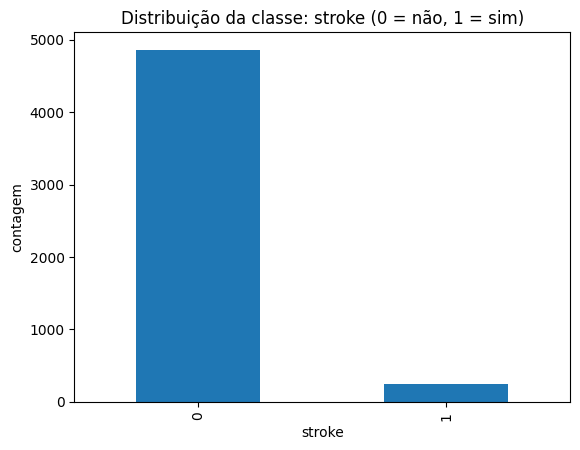

In [5]:
counts = df["stroke"].value_counts().sort_index()
plt.figure()
counts.plot(kind="bar")
plt.title("Distribuição da classe: stroke (0 = não, 1 = sim)")
plt.xlabel("stroke")
plt.ylabel("contagem")
plt.show()

A classe 1 (AVC) é minoria, então o conjunto é desbalanceado. Por isso, além da accuracy, vamos avaliar F1 (equilibra precisão e recall).


In [6]:
if "id" in df.columns:
    df = df.drop(columns=["id"])

target = "stroke"
y = df[target].astype(int)
X = df.drop(columns=[target])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))

Numéricas: 5 | Categóricas: 5


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Proporção positivos (train/test):", y_train.mean().round(4), "/", y_test.mean().round(4))

Train: (4088, 10) | Test: (1022, 10)
Proporção positivos (train/test): 0.0487 / 0.0489


In [8]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(transformers=[
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Após pré-processamento - treino:", X_train_proc.shape, "| teste:", X_test_proc.shape)

Após pré-processamento - treino: (4088, 21) | teste: (1022, 21)


In [9]:
input_dim = X_train_proc.shape[1]

model = Sequential([
    Dense(1, activation="sigmoid", input_shape=(input_dim,))
])

model.compile(
    optimizer=Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train_proc, y_train,
    epochs=50,
    batch_size=10,
    validation_split=0.2,
    verbose=0
)
print("Treinamento concluído.")

Treinamento concluído.


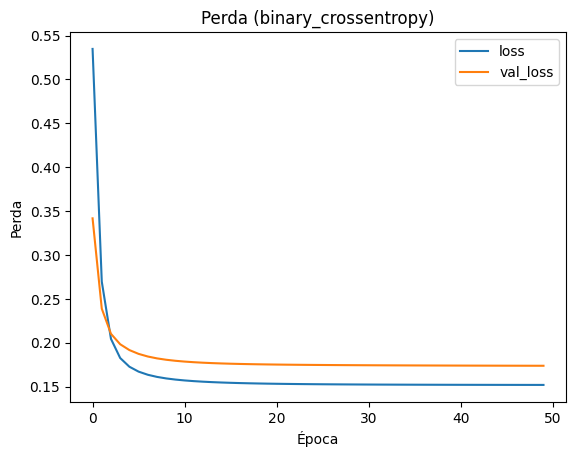

In [11]:
plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Perda (binary_crossentropy)")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.show()


Loss (treino) e val_loss (validação) devem cair e estabilizar.  
Se val_loss sobe enquanto loss cai, sinal de overfitting.


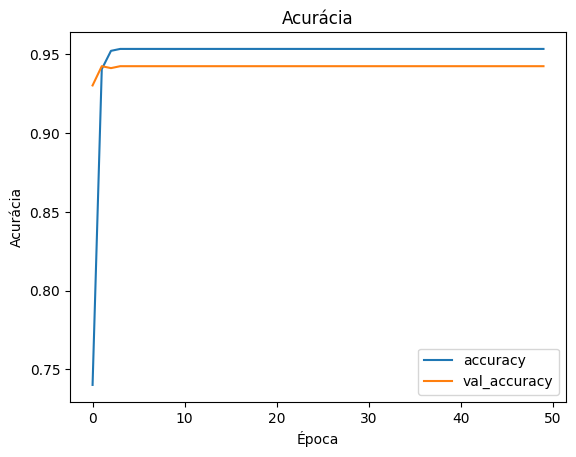

In [12]:
plt.figure()
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

Accuracy e val_accuracy subindo e estabilizando indicam convergência.  
Gap grande entre treino e validação pode indicar overfitting.


In [13]:
y_prob = model.predict(X_test_proc).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print(f"Accuracy (teste): {acc:.4f}")
print(f"F1 (teste)      : {f1:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy (teste): 0.9521
F1 (teste)      : 0.0392


Durante o treino, usei o otimizador Adam, que basicamente é quem ajusta os pesos do modelo de forma automática e adaptativa pra ele aprender mais rápido. A função de perda escolhida foi a binary_crossentropy, que mede o quanto as previsões estão erradas quando a gente está lidando com um problema de duas classes. Como métrica principal, olhei a accuracy, que mostra a porcentagem de acertos, mas também calculei a F1, que é importante quando as classes estão desbalanceadas, porque leva em conta tanto o quanto acertamos dos positivos quanto o quanto evitamos falsos alarmes.

O resultado mostrou que o perceptron, sendo um modelo simples e linear, serve bem como ponto de partida, mas pode ter dificuldade pra capturar relações mais complexas entre as variáveis. Se a accuracy ficou boa mas a F1 não acompanhou, isso pode ser por causa do desbalanceamento, já que tem bem menos casos de AVC no conjunto de dados.

Pra melhorar, dá pra testar um modelo mais complexo, como uma rede com camadas extras, que consiga entender padrões mais complicados. Também dá pra lidar com o desbalanceamento usando técnicas como ajustar o peso das classes ou gerar mais exemplos da classe menor. Outra ideia é mexer no limite de decisão, que hoje está em 0.5, pra ver se conseguimos aumentar o recall sem perder tanto na precisão. Além disso, criar novas variáveis ou transformar algumas que já existem pode ajudar o modelo a ter mais informações úteis pra aprender.
